# Searching for point sources in neutrino data

Marcos Santander - Univ. of Alabama (jmsantander@ua.edu)

ISAPP 2022 - https://indico.ijclab.in2p3.fr/event/7633/

## Goals, requirements, and additional material

#### Goals for this excercise

This tutorial is meant to give an idea of basic methods to look for sources. It *is not* meant to be a full implementation of the standard IceCube tools. The main goals for this exercise are:

* Understanding the properties of the IceCube muon track data set for point-source searches.
* Describe basic techniques to search for an excess of neutrino events.
* Correlate neutrino observations with the positions of known electromagnetic sources.
* Introduce the point-source likelihood search method.

#### Required libraries

The main libraries we'll use beyond the standard ones (`matplotlib`, `numpy`, `pylab`) are `scipy`, `urllib3` and `healpy`. To install:

`pip install matplotlib numpy astropy healpy urllib3`

#### Additional material

Here are some papers that provide more information about point source searches in IceCube:
* The main search method for point-sources used in IceCube [Paper](https://arxiv.org/abs/0801.1604).
* IceCube search for point sources with 10 years of data [Paper](https://arxiv.org/abs/1910.08488).
* The dataset used in this example [Link](https://icecube.wisc.edu/data-releases/2016/11/search-for-point-sources-with-first-year-of-ic86-data/) and the paper [Paper](https://arxiv.org/abs/1406.6757).

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import healpy as hp
#import urllib
import urllib.request

import matplotlib as mpl
import scipy as sp
from astropy.io import fits
from scipy.interpolate import interp1d, UnivariateSpline

pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['figure.figsize'] = (8, 6.0)
pl.rcParams['font.size'] = 18
pl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['font.family'] = 'CMU Sans Serif'

cmap_maps=mpl.cm.get_cmap("RdBu_r").copy()
cmap_maps.set_bad('white')
cmap_maps.set_under('white')


degree = np.pi / 180.

## 1) Getting the data

Let's get some data. The data that will be used here comes from the public release of the first year of IceCube data from the completed IC86 detector. The data was used in this paper: https://arxiv.org/abs/1406.6757 and additional details are provided in the public release page: https://icecube.wisc.edu/science/data/PS-IC86-2011

In [2]:
#urllib.urlretrieve('http://www.nevis.columbia.edu/~santander/ic_events.txt', 'ic_events.txt')
data = urllib.request.urlretrieve('http://www.nevis.columbia.edu/~santander/ic_events.txt', 'ic_events.txt')

icevents = np.genfromtxt("ic_events.txt", names=True)

There are 138322 neutrino event candidates in this set

In [3]:
len(icevents)

138322

## Plotting some variables

### Declination and energy distributions

Let's look at the distribution of event declinations in the data set. 

In [4]:
icevents['Dec'] * degree

array([-0.39444441, -0.66322512, -0.89011792, ...,  0.90233522,
        0.64577182,  1.17111593])

Text(0.5, 0, 'sin($\\delta$)')

findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


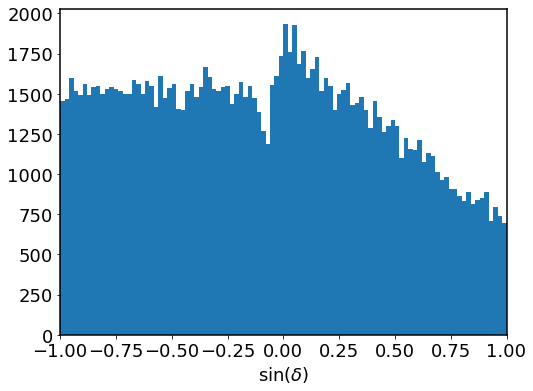

In [5]:
pl.hist(np.sin(icevents['Dec'] * degree),range=(-1,1),bins=100)
pl.xlim(-1,1)
pl.xlabel('sin($\delta$)')

For this analysis, the effective area of IceCube peaks near the horizon ($\delta = 0^{\circ}$) as can be seen in the effective area plots from the ten-year paper as a function of energy below (*Right*) <a href="https://arxiv.org/abs/1910.08488">Ref</a>. The effect of neutrino absorption is evident at high energies for neutrinos in the northern sky ($\delta > 0$) as they come through the Earth.

In the southern sky, a high background of atmospheric muons is removed by implementing energy cuts, and as a result the median energy of the sample increases above the horizon (*Left*). 


<img src='http://www.nevis.columbia.edu/~santander/ic_aeff_energy.png'/>

This can also be seen in the data if we plot the $\sin(\delta)$ vs $\log(E)$, where logE is not the true neutrino energy but a proxy estimator.

Text(0, 0.5, 'log$_{10}$(E) [GeV]')

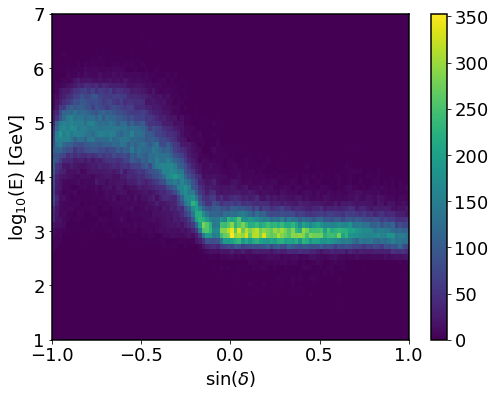

In [6]:
h = pl.hist2d(np.sin(icevents['Dec'] * degree), icevents['log10E'], bins=(100,61),range=([-1,1], [1,7]))
pl.colorbar(h[3])
pl.xlabel('sin($\delta$)')
pl.ylabel('log$_{10}$(E) [GeV]')

### Average candidate neutrino rate

The range and duration of our sample is

In [7]:
#print "From: ", min(icevents['MJD']), "to", max(icevents['MJD']), "(",max(icevents['MJD'])-min(icevents['MJD']), " days )"

(55694.0, 56062.0)

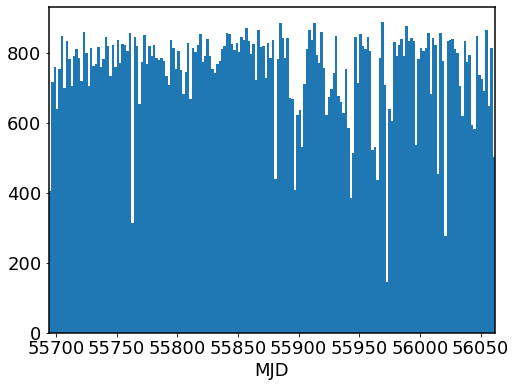

In [8]:
pl.hist(icevents['MJD'], bins=184, range=(55694, 56062))
pl.xlabel('MJD')
pl.xlim(min(icevents['MJD']), max(icevents['MJD']))

The rate is pretty flat, although not perfectly so. There are period with less neutrino candidates than average due to quality cuts implemented on the runs used in the analysis.

### Sky map

We'll use <a href='https://healpix.jpl.nasa.gov/'>HEALPix</a> to create counts map of neutrinos. The binning parameter *Nside* is set to 32, which means that the <a href='http://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm'>average pixel spacing</a> is ~1.8$^{\circ}$. This binning is now optimal for the PSF of IceCube, but it will allow us to look at features in the sky distribution of these neutrino event candidates.

findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


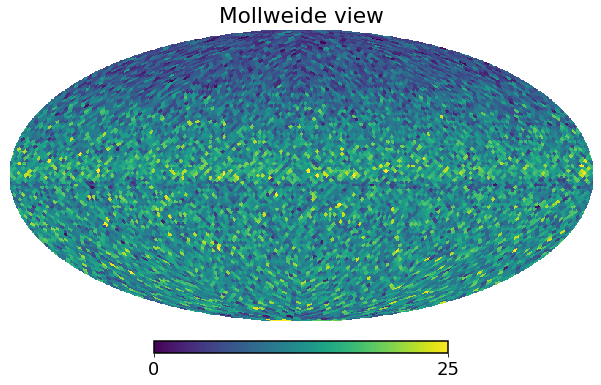

In [9]:
nside = 32
npixs = hp.nside2npix(nside)

# get HEALPix thetas and phis (in radians) from RA and Decs (in degrees)

def getThetaPhi(RA, Dec):
    theta = (90 - Dec) * degree
    phi = RA * degree
    return (theta, phi)


(theta, phi) = getThetaPhi(icevents['RA'], icevents['Dec'])

# Create and fill the map with events
hmap = np.zeros(npixs)
pixs = hp.ang2pix(nside, theta, phi)

for p in pixs:
    hmap[p] += 1
    
    
# Plot the map
hp.mollview(hmap,max=25)

The banding is a result of cuts and differences in the effective area for upgoing and downgoing events already described. The good news is that, on long time scales, the response of IceCube if fairly homogeneous in RA as shown in the plot below.

No obvious excess of events can be seen by eye, so we need to come up with a statistical test to look for sources.

Text(0.5, 0, '$\\alpha$ [$^{\\circ}$]')

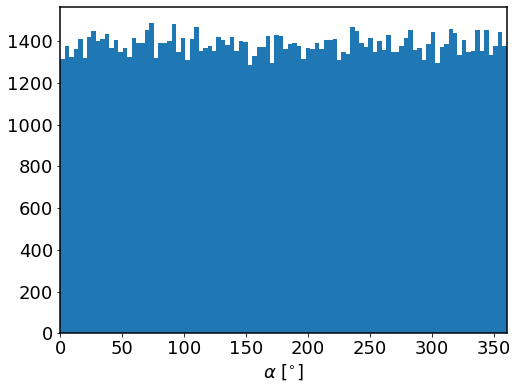

In [10]:
pl.hist(icevents['RA'],range=(0,360),bins=100)
pl.xlim(0,360)
pl.xlabel(r"$\alpha$ [$^{\circ}$]")

### Angular resolution

The angular resolution should improve vs energy, although it is a bit hard to see.

Text(0, 0.5, 'Angular error [$^{\\circ}$]')

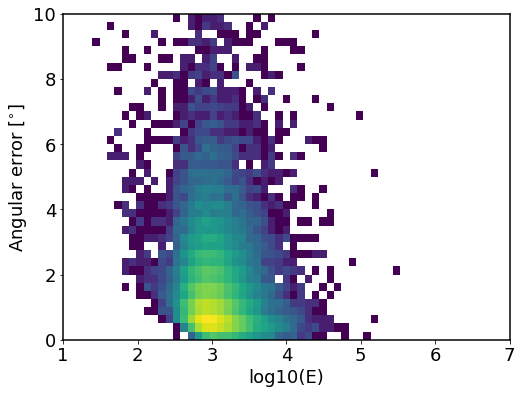

In [11]:
selection = (icevents['Dec'] > 0)

h1 = pl.hist2d(icevents[selection]['log10E'], icevents[selection]['ang_err'], bins=(61,40),range=([1,7], [0,10]), norm=mpl.colors.LogNorm())

#avg_err = []
#sigma_err = []

#for i in range(h1[0].shape[0]):
#    c = h1[0][i]
#    avg_err.append(np.average(c))
#    sigma_err.append(np.std(c))


pl.xlabel('log10(E)')
pl.ylabel('Angular error [$^{\circ}$]')

# Looking for hotspots

Let's start with something easy. We want to see if any of the event clusterings in the skymap is statistically significant. For that, we need to compare the number of detected events to what we would expect in that bin if there were no sources (the background-only hypothesis).

To estimate the background level, we scramble the RAs of the events while keeping the Dec constant and produce new maps. These maps have the same statistical properties as our 'real data' map but are scrambled so it should contain no significant structure.

We'll create 20 scrambles and add the maps together. 

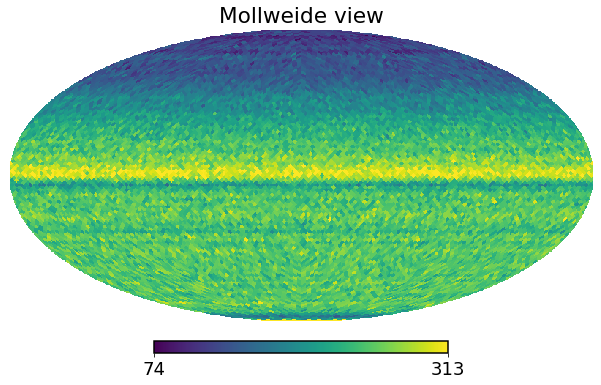

In [12]:
scramble_map = np.zeros(npixs)
Nscramble = 20

def scrambleRA(ras):
    return np.random.random(len(ras))*360

for s in range(Nscramble):
    ra = scrambleRA(icevents['RA'])
    
    (theta, phi) = getThetaPhi(ra, icevents['Dec'])
    
    pixs = hp.ang2pix(nside, theta, phi)

    for p in pixs:
        scramble_map[p] += 1
    
    
# Plot the map
hp.mollview(scramble_map, max=np.percentile(scramble_map, 99))

As you can see, the map has retained the declination features. The statistics are much higher (by x20) so it looks much smoother.

For each pixel, we now have a number of observed events and an expected number based on the scrambling method. Let's compare both and see what kind of statistical significances we get. For this crude example we'll use Eq. 17 of the the <a href="http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983ApJ...272..317L&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf">Li&Ma paper</a>  which is widely used in VHE gamma astronomy. 

Following the Li&Ma we set $\alpha = 1/20$ as our OFF/ON ratio (the ratio between the statistics in the "signal" and "background" maps).

In [13]:
def LiMa(Non, Noff, alpha):
    A = Non * np.log( ((1+alpha)/alpha)  * (Non/(Non+Noff)))
    B = Noff * np.log( (1+alpha)  * (Noff/(Non+Noff)))
    
    sign = np.ones(len(Non))

    sign[Non < Noff * alpha] = -1
    
    return sign * np.sqrt(2 * (A+B))

# This is a list of significances per pixel
sigma = LiMa(hmap, scramble_map, alpha=1/20.)

<ipython-input-13-a6a35f2a5dc2>:2: RuntimeWarning: divide by zero encountered in log
  A = Non * np.log( ((1+alpha)/alpha)  * (Non/(Non+Noff)))
<ipython-input-13-a6a35f2a5dc2>:2: RuntimeWarning: invalid value encountered in multiply
  A = Non * np.log( ((1+alpha)/alpha)  * (Non/(Non+Noff)))


Let's look at the map of significances and see what's the maximum significance in the map.

3.5950367567823074


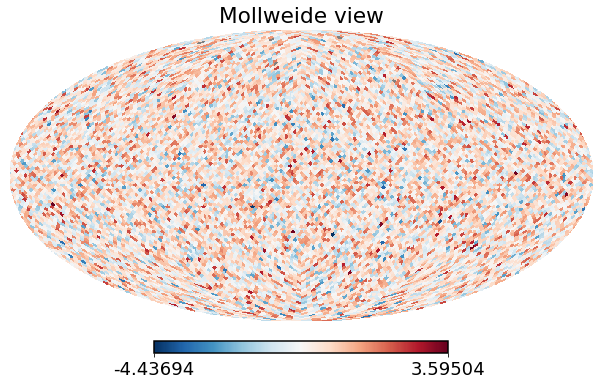

In [14]:
hp.mollview(sigma, cmap=cmap_maps, rot=180)
print(max(sigma))

Wow! a $>3\sigma$ excess! Should you publish a paper? Probably not, because you've looked at 12288 pixels in the sky, so finding $>3\sigma$ fluctuations is not *that* rare. Let's see how the significance histogram looks like.

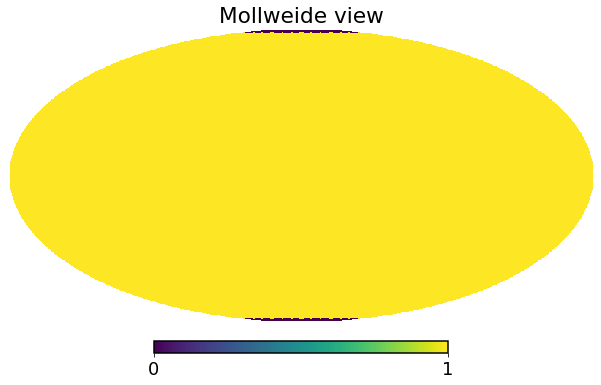

In [15]:
# Due to the way that the background is estimated, this doesn't work too well close to 
# the poles so we'll cut 5 degrees around each pole.

# O make me a mask
mask = np.ones(len(sigma))

(theta, phi) = hp.pix2ang(nside, range(len(sigma)))

mask[np.abs(90 * degree - theta) > 85 * degree] = 0

hp.mollview(mask)

[8.22168146e+02 4.17322902e-02 9.86984320e-01]


(1, 1000)

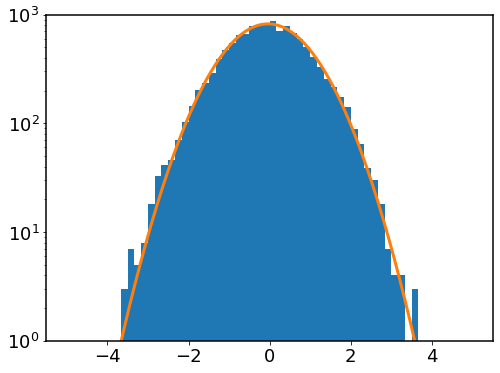

In [16]:
masked_sigma = mask * sigma

a = pl.hist(masked_sigma, bins=60, range=(-5,5))
pl.yscale('log')

s = np.linspace(-5,5,300)

def Gaussian(x, *p):
    return p[0] * np.exp(-(x + p[1])**2/(2*p[2]**2))

# A unit Gaussian looks like a reasoanable fit to the significance distribution, 
# and the excess looks consistent with background fluctuations.

from scipy.optimize import curve_fit
from scipy import optimize
p0 = [1000, 0, 1.]
bin_center = (a[1][1:] + a[1][:-1])/2.

coeff, var_matrix = curve_fit(Gaussian, bin_center, a[0], p0=p0)
print(coeff)

# Get the fitted curve
hist_fit = Gaussian(s, *coeff)

pl.plot(s, hist_fit, linewidth=3)

pl.ylim(1,1000)

### Trials

We said that the $3.7\sigma$ doesn't look too remarkable because we looked at many pixels. How can we quantify this?

* The easy way: if the p-value associated with the significance is small, we can just multiply it by the number of trials to get an 'after trials' p-value.

* The harder way: we can generate Monte Carlo simulations of the data (in our case, generate random data sets like the ones we used to estimate the background) and see how often we get a p-value better than the pre-trials one in random generations. The issue here is that if we have a small p-value, we would have to generate simulations to sample it.

In [17]:
def gauss_cdf(sigma):
    return 0.5 * (1 + sp.special.erf(sigma/np.sqrt(2)))

# we calculate the p-value associated with the significance
smax = 3.6
pvalue = 1 - gauss_cdf(smax)

# the number of trials in the number of pixels
ntrials = len(masked_sigma)

paftertrials = ntrials * pvalue

print("Pre-trials p:", pvalue)
print("Post-trials p:", paftertrials)

Pre-trials p: 0.00015910859015755285
Post-trials p: 1.9551263558560095


The post-trials p-value is >1, which is obviously something you don't want in a p-value, but it esentially means that the post-trials p-value is not significant and to actually get a good estimate we would have to do so Monte Carlo, we we won't...

## Other angular scales

So far, we've looked for a neutrino hotspot on each pixel individually, but the pixel size (1.8°) is larger than the PSF of IceCube (~< 1°), and it could also be that the size is larger than the PSF for a extended Galactic source.

We can explore other angular scales by "smoothing" the map, which correlates pixels over a larger angular scale than the pixel size. Let's see how the map looks when we smooth it by 2° radius. For this we'll start with a higher resolution map which we'll smooth.

In [18]:
smooth_radius = 2 * degree

nside = 128
npixs = hp.nside2npix(nside)

(theta, phi) = getThetaPhi(icevents['RA'], icevents['Dec'])

# Create and fill the map with events
hmap = np.zeros(npixs)
pixs = hp.ang2pix(nside, theta, phi)

for p in pixs:
    hmap[p] += 1
    

def smooth_map(hmap, radius=3*degree):
    smap = np.zeros(len(hmap))
    
    for i in range(npixs):
        v = hp.pix2vec(nside,i)
        qpixs = hp.query_disc(nside,v, radius=radius)
        smap[i] = np.sum(hmap[qpixs])
    
    return smap

smap = smooth_map(hmap, smooth_radius)

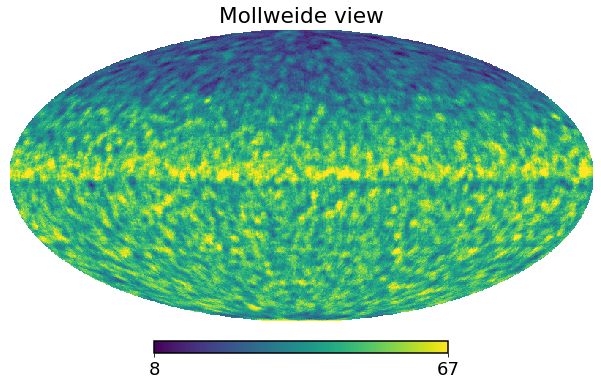

In [19]:
hp.mollview(smap,  max=np.percentile(smap, 99))

In [20]:
scramble_map = np.zeros(npixs)
Nscramble = 20

def scrambleRA(ras):
    return np.random.random(len(ras))*360

for s in range(Nscramble):
    ra = scrambleRA(icevents['RA'])
    
    (theta, phi) = getThetaPhi(ra, icevents['Dec'])
    
    pixs = hp.ang2pix(nside, theta, phi)

    for p in pixs:
        scramble_map[p] += 1

smap_scramble = smooth_map(scramble_map, smooth_radius)

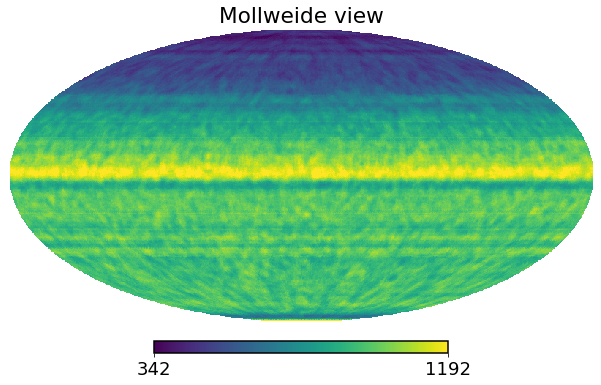

In [21]:
# Plot the map
hp.mollview(smap_scramble, max=np.percentile(smap_scramble, 99))

0.0 180.0 -180.0 180.0


4.632329209269106


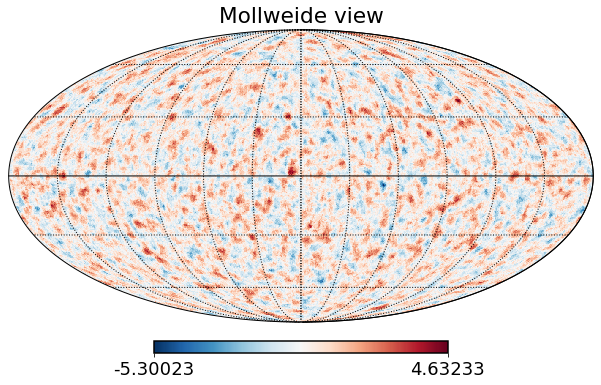

In [22]:
sigma_smooth = LiMa(smap, smap_scramble, alpha=1/20.)
hp.mollview(sigma_smooth, cmap=cmap_maps, rot=180)
hp.graticule()
print(max(sigma_smooth))

Let's zoom in into the location of the excess to see how it looks.

0.0 180.0 nan nan


Max significance: 4.632329209269106
Pixel with max sigma 96264
185.97656249999997 1.1937484371410676
-174.02343750000003 1.1937484371410676


ValueError: arange: cannot compute length

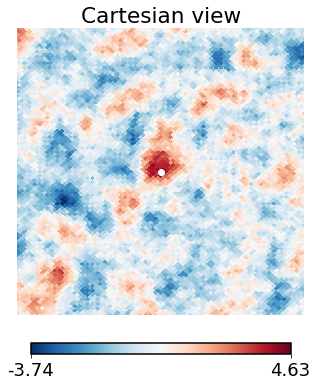

In [23]:
pixmax = np.argmax(sigma_smooth)
print("Max significance:",  max(sigma_smooth))
print("Pixel with max sigma", pixmax)

(thetamax, phimax) = hp.pix2ang(nside, pixmax)

ramax = phimax/degree
decmax = 90 - thetamax / degree

print(ramax, decmax)

lonmax = ramax
if lonmax > 180:
    lonmax = -360 + lonmax

box = 20

print(lonmax, decmax)

hp.cartview(sigma_smooth, latra=[decmax-box, decmax+box], \
            lonra=[lonmax-box, lonmax+box], cmap=cmap_maps)
hp.projscatter(thetamax, phimax, color='white', marker='o')

hp.graticule()

[1.32750987e+04 3.72834875e-02 9.81107721e-01]


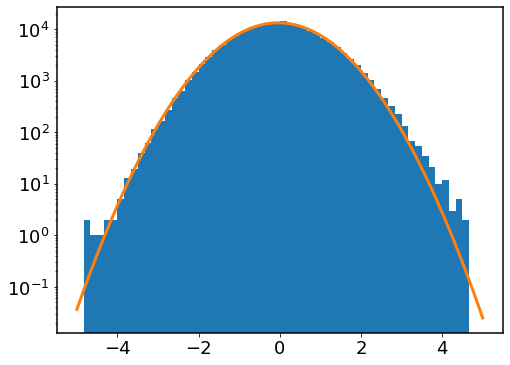

In [24]:
# Create a new mask
smask = np.ones(npixs)

(theta, phi) = hp.pix2ang(nside, range(npixs))

smask[np.abs(90 * degree - theta) > 85 * degree] = 0

masked_sigma_smooth = smask * sigma_smooth

a = pl.hist(masked_sigma_smooth, bins=60, range=(-5,5))
pl.yscale('log')


s = np.linspace(-5,5,300)

def Gaussian(x, *p):
    return p[0] * np.exp(-(x + p[1])**2/(2*p[2]**2))

# A unit Gaussian looks like a reasoanable fit to the significance distribution, 
# and the excess looks consistent with background fluctuations.

from scipy.optimize import curve_fit
from scipy import optimize
p0 = [1000, 0, 1.]
bin_center = (a[1][1:] + a[1][:-1])/2.

coeff, var_matrix = curve_fit(Gaussian, bin_center, a[0], p0=p0)
print(coeff)

# Get the fitted curve
hist_fit = Gaussian(s, *coeff)

pl.plot(s, hist_fit, linewidth=3)



There's now something a little higher in significance (4.4), let's correct for trials. You may get slightly different values which could be related to background fluctuations. To reduce this you can generate more background realizations.  

We could claim that this is the first time we've looked at a skymap, but the fact that we've now looked at two angular scales (pixel size and 2 deg smoothing) has to be accounted for somehow in our correction. We just use 2 as the number of trials due to angular scales examined.

In [25]:
# we calculate the p-value associated with the significance
smax = 4.4
pvalue = 1 - gauss_cdf(smax)

# the number of trials in the number of pixels
ntrials_pix = len(masked_sigma) 

# number of trials due to angular scales examined
ntrials_ang = 2

paftertrials = ntrials_pix * ntrials_ang * pvalue

print("Pre-trials p:", pvalue)
print("Post-trials p:", paftertrials)

Pre-trials p: 5.412543907734602e-06
Post-trials p: 0.13301867907648557


## What about Fermi sources?

Again, a disclaimer as this is just an illustration of an idea!

In [26]:
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/12yr_catalog/gll_psc_v28.fit', 'gll_psc_v28.fit')
hdulist = fits.open("gll_psc_v28.fit")

h, data, columns = hdulist[1].header, hdulist[1].data, hdulist[1].columns

sel = np.abs(data['GLAT']) > 10

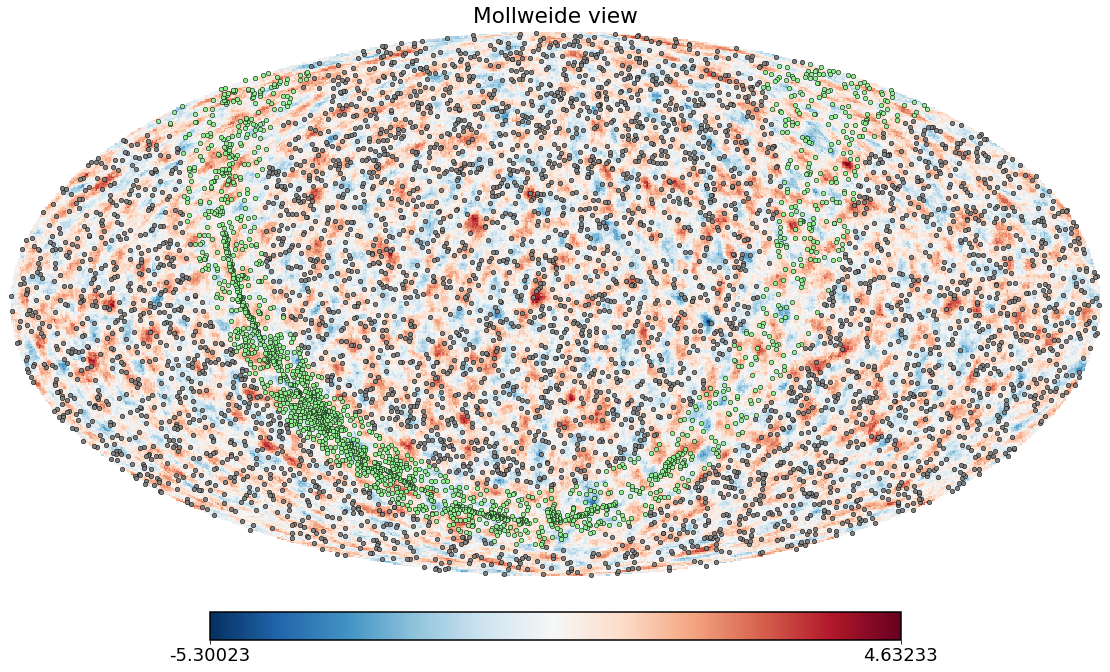

In [27]:
fig = pl.figure(figsize=(20,10))
hp.mollview(sigma_smooth, fig=1, cmap=cmap_maps, rot=180)
hp.projscatter(data[sel]['RAJ2000'], data[sel]['DEJ2000'], lonlat=True, s=20, color='gray', marker='o', linewidth=0.5, edgecolor='black')
hp.projscatter(data[~sel]['RAJ2000'], data[~sel]['DEJ2000'], lonlat=True, s=20, color='lightgreen', marker='o', linewidth=0.5, edgecolor='black')


#hp.graticule()

Instead of looking at the entire sky for an excess of events, we can look at known Fermi source positions and stack the number of neutrino candidate events. If the sources are too dim to be detected individually, this approach may reveal an overall excess of events from the Fermi source positions.

We will only look at sources at high Galactic latitudes ($b > 10^{\circ}$) and stack all events within a pre-defined radius that goes between 0.3 to 10 degrees. It must be noted that each one of these radii constitutes an statistical trial which must be accounted for, although these trials are very correlated (i.e. the number of neutrino events within, say, 0.4 deg of Fermi sources is not very different from that within 0.3 deg).

In [28]:
radscan = np.linspace(0.3,10, num=100)

Nons = []
Noffs = []

hmap_masked = smask * hmap
scramble_map_masked = scramble_map * smask

for radius in radscan:

    Non = 0
    Noff = 0

    # Let's only look at "extragalactic" sources
    
    for s in data[np.abs(data['GLAT']) > 10]:
        theta = (90 - s['DEJ2000']) * degree
        phi = s['RAJ2000'] * degree
    
        v = hp.ang2vec(theta,phi)
        pixs = hp.query_disc(nside,v,radius*degree)
        
        Non += np.sum(hmap_masked[pixs])
        Noff += np.sum(scramble_map_masked[pixs])
    
    Nons.append(Non)
    Noffs.append(Noff)

Also note here that we're not taking into account the energy of the events. 

Text(0, 0.5, 'Pre-trial significance [$\\sigma$]')

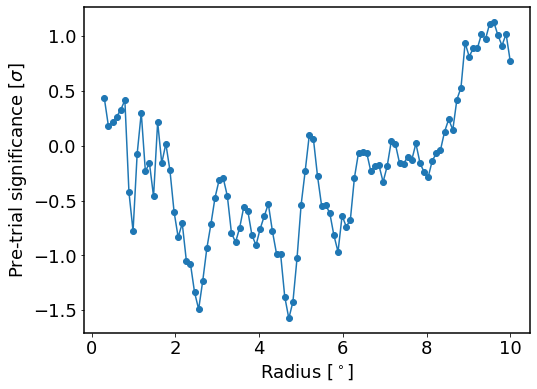

In [29]:
sigscan = LiMa(np.array(Nons),np.array(Noffs), 1/20.)
pl.plot(radscan, sigscan,marker='o')
pl.xlabel('Radius [$^\circ$]')
pl.ylabel('Pre-trial significance [$\sigma$]')

# Unbinned likelihood analysis

For its standard neutrino point-source analysis IceCube uses an unbinned likelihood analysis approach that takes into account the energy and angular uncertainty on each neutrino candidate event. For each position in the sky, a source is assumed to contribute with a number of neutrino events ($n_s$) and to have a power-law spectrum $\propto E^{-\gamma}$ with spectral index $\gamma$. 

The "signal" probability distribution function is modeled as a 2D Gaussian, with angular error provided by the event reconstruction, and the background is assumed to be uniform in RA with a strong Dec dependence. 

We'll simplify the algorithm to fit only for the number of source events ($n_s$), so the likelihood reads:

${\cal L}(n_s) = \Pi_i \frac{n_s}{N} {\cal S}_i + (1 - \frac{n_s}{N}) {\cal B}_i$

We'll use the standard IceCube ps analysis method. A good description is available in <a href='https://docushare.icecube.wisc.edu/dsweb/Get/Document-72853/Feintzeig_Thesis.pdf'>Jake Feintzeig's thesis (Chapter 6)</a>.



Over all events (i) in the sample. We'll take a log of the likelihood function, so the equation becomes a sum.


In [30]:
def openingAngle(ra0, dec0, ra1, dec1):
    v0 = hp.ang2vec(ra0, dec0, lonlat=True)
    v1 = hp.ang2vec(ra1, dec1, lonlat=True)
    
    dp = np.dot(v0,v1)
    return np.arccos(dp) / degree


def getBkgFunction(icevents):
    sinBins = 40
    histo = np.histogram(np.sin(icevents['Dec'] * degree),range=(-1,1),bins=sinBins)

    ds = 2./sinBins
    A = len(icevents) * ds * 2*np.pi
    
    bincenters = (histo[1][1:] + histo[1][:-1]) / 2.
    counts = histo[0] / A
    func = UnivariateSpline(bincenters, counts, s=0)
    return func


def LLHFunction(events, raS, decS, ns, bkg):
    # We need the position, angular resolution, and total number of events. 
    # We also need the background distribution of events in sin(delta)
    
    raEvent = events['RA']
    decEvent = events['Dec']
    angres = events['ang_err']
    
    N = len(events)
    
    r = openingAngle(raEvent, decEvent, raS, decS)
    S = np.exp(-r**2/(2*angres**2)) / (2 * np.pi * (angres*degree)**2)
    
    B = bkg(np.sin(decEvent * degree))

    llh = np.log(ns * S / float(N) + (1 - ns/float(N)) * B)
    
    return llh[llh == llh]




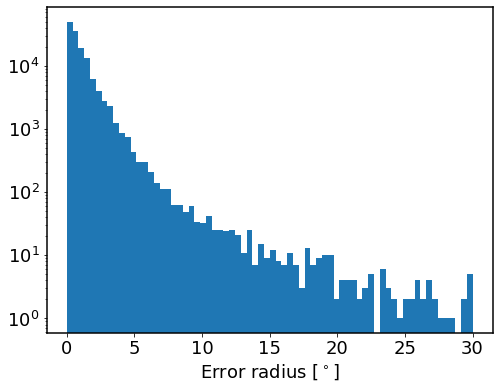

In [31]:
# The error radius of the events in our sample 
a = pl.hist(icevents['ang_err'],range=(0,30),bins=70)
pl.xlabel('Error radius [$^\circ$]')
pl.yscale('log')

Let's look at the events in one small 10x10 deg piece of sky centered on RA = 208 deg, Dec = 23 dec.

Text(0, 0.5, '$\\delta [^{\\circ}$]')

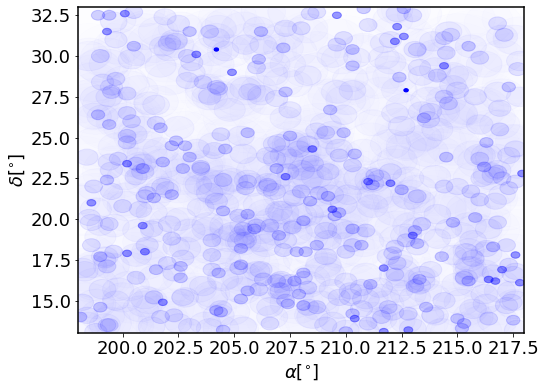

In [32]:
fig, ax = pl.subplots()

dra = 10
ddec = 10

ra0 = 208
dec0 = 23

for event in icevents:
    if np.abs(event['RA'] - ra0) < dra and np.abs(event['Dec'] - dec0) < ddec:
        areaPSF = np.pi * event['ang_err']**2
        alpha = 0.05/areaPSF
        if alpha > 1:
            alpha = 1
        c1 = pl.Circle((event['RA'], event['Dec']), radius=event['ang_err'], color='blue', alpha=alpha)
        ax.add_artist(c1)

#pl.scatter(icevents['RA'], icevents['Dec'])
pl.xlim(ra0-dra,ra0+dra)
pl.ylim(dec0-ddec,dec0+ddec)
pl.xlabel(r'$\alpha [^{\circ}$]')
pl.ylabel(r'$\delta [^{\circ}$]')

In [33]:
raS = 208
decS = 23
N = len(icevents)

nsources = np.linspace(0, 50, num=100)
bkg = getBkgFunction(icevents)

llhs = []

from scipy.optimize import minimize

#res = minimize(-np.sum(LLHFunction(icevents, raS, decS, ns, bkg), x0, method='Nelder-Mead', tol=1e-6) 
               
for ns in nsources: 
    llhs.append(-np.sum(LLHFunction(icevents, raS, decS, ns, bkg)))

<ipython-input-30-771c73567541>:33: RuntimeWarning: divide by zero encountered in true_divide
  S = np.exp(-r**2/(2*angres**2)) / (2 * np.pi * (angres*degree)**2)
<ipython-input-30-771c73567541>:33: RuntimeWarning: invalid value encountered in true_divide
  S = np.exp(-r**2/(2*angres**2)) / (2 * np.pi * (angres*degree)**2)


Best-fit n_s: 12.626262626262626


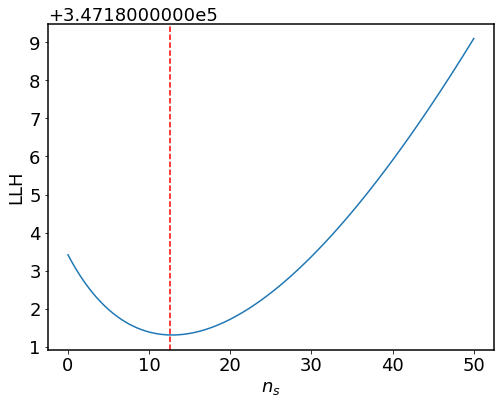

In [34]:
pl.plot(nsources, llhs)
pl.xlabel('$n_s$')
pl.ylabel('LLH')

ns_fit = nsources[np.argmin(llhs)]
pl.axvline(ns_fit, color='red', linestyle='--')
print("Best-fit n_s:", ns_fit)

Using this value for n_s, the effective area and the exposure we can estimate a neutrino flux. 